# Overview
This notebook will demonstrate the preprocessing of scRNA-seq data about mouse hematopoietic stem cells differentiation.
The original data is obtained from: *Nestorowa, S., Hamey F.K., Pijuan Sala B., et al. A single-cell resolution map of mouse hematopoietic stem and progenitor cell differentiation. Blood, 128(8): e20-e31 (2016).* <https://doi.org/10.1182/blood-2016-05-716480>


### Contents
- [1. Load data](#section1)
- [2. Convert Ensembl ID to gene symbol](#section2)
- [3. Define cell labels](#section3)
- [4. Make Anndata object](#section4)
- [5. Filtering, normalization and log transformation](#section5)
- [6. High variable genes](#section6)
- [7. PCA, KNN-graph and cell clustering](#section7)
- [8. Dimensionality reduction and visualization](#section8)
- [9. Trajectory inference and differential expression analysis](#section9)
- [10. Save the preprocessed data](#section10)

In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
import scanpy as sc
import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # svg

sc.settings.set_figure_params(dpi=80,
                              dpi_save=300,
                              frameon=False,
                              figsize=(4, 4),
                              fontsize=13,
                              facecolor='white',
                              color_map='viridis_r',
                              )

# Reset random seed
np.random.seed(2022)

<a id="section1"></a>
## 1. Load data

Read counts data can be downloaded from <https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE81682>.
Cell type labels can be downloaded from <https://blood.stemcells.cam.ac.uk/data/>. The following lines can be used to download these data in a Unix-based system:
&nbsp;
```python
!mkdir mHSC_Nestorowa16_data
!wget -P ./mHSC_Nestorowa16_data/ https://ftp.ncbi.nlm.nih.gov/geo/series/GSE81nnn/GSE81682/suppl/GSE81682_HTSeq_counts.txt.gz
!wget -P ./mHSC_Nestorowa16_data/ http://blood.stemcells.cam.ac.uk/data/{all_cell_types.txt,cluster_ids.txt}
```

In [4]:
read_counts = pd.read_csv('mHSC_Nestorowa16_data/GSE81682_HTSeq_counts.txt.gz', sep='\t', index_col=0)
cell_types = pd.read_csv('mHSC_Nestorowa16_data/all_cell_types.txt', sep='\t', index_col=0)
cluster_ids = pd.read_csv('mHSC_Nestorowa16_data/cluster_ids.txt', sep=' ', header=None, index_col=0, names=['cluster'])

read_counts = read_counts.loc[:, cluster_ids.index]
read_counts = read_counts.loc[read_counts.index.str.startswith('ENS'), :]
cell_types = cell_types.loc[read_counts.columns, ]

<a id="section2"></a>
## 2. Convert Ensembl ID to gene symbol

In [5]:
import biomart

server = biomart.BiomartServer('http://asia.ensembl.org/biomart/')  # http://useast.ensembl.org/biomart
mouse_dataset = server.datasets['mmusculus_gene_ensembl']
mouse_attributes = ['ensembl_gene_id', 'mgi_symbol']  # 'external_gene_name'
filters = {'biotype': 'protein_coding'}

query = mouse_dataset.search({'attributes': mouse_attributes, 'filters':filters})
query = query.raw.data.decode('ascii').split('\n')[:-1]
query = pd.DataFrame([d.split('\t') for d in query], columns=['ensembl_gene_id', 'mgi_symbol'])
query.index = query['ensembl_gene_id']
query.index.name = None
query.drop_duplicates(['mgi_symbol'], keep='first', inplace=True) # duplicated gene name
query.drop_duplicates(['ensembl_gene_id'], keep='first', inplace=True) # duplicated gene name
query = query[query['mgi_symbol']!='']

# delete unmatched ensembl ids
gene_list = [query.loc[x, 'mgi_symbol'] if (x in query.index) else x for x in read_counts.index]
read_counts.index = gene_list
gene_index = [i for i,x in enumerate(gene_list) if not x.startswith('ENS')]
read_counts = read_counts.iloc[gene_index, :]
print(read_counts.shape)

(21086, 1656)


<a id="section3"></a>
## 3. Define cell labels

In [6]:
HSC_group = ['LTHSC_broad','LTHSC','STHSC_broad','STHSC','ESLAM','HSC1']
LMPP_group = ['LMPP_broad','LMPP']
MPP_group = ['MPP_broad','MPP1_broad','MPP2_broad','MPP3_broad','MPP','MPP1','MPP2','MPP3']
CMP_group = ['CMP_broad','CMP']
MEP_group = ['MEP_broad','MEP']
GMP_group = ['GMP_broad','GMP']

# Combine similar subtypes into one cell type
cell_labels = pd.DataFrame(index=cell_types.index)
cell_labels['HSC'] = cell_types[HSC_group].sum(axis=1)
cell_labels['LMPP'] = cell_types[LMPP_group].sum(axis=1)
cell_labels['MPP'] = cell_types[MPP_group].sum(axis=1)
cell_labels['CMP'] = cell_types[CMP_group].sum(axis=1)
cell_labels['MEP'] = cell_types[MEP_group].sum(axis=1)
cell_labels['GMP'] = cell_types[GMP_group].sum(axis=1)
cell_labels = cell_labels.applymap(lambda x: 1 if x != 0 else 0)
cell_labels_more = cell_types[['ESLAM','LTHSC_broad','LMPP_broad','MPP_broad','CMP_broad',
                               'MEP_broad','GMP_broad','MPP1_broad','MPP2_broad','MPP3_broad','STHSC_broad']]

def non_zero_columns(row):
    labels = list(row.index[row != 0])
    if len(labels) > 1:
        np.random.seed(2023)
        x_label = np.random.choice(labels, 1)[0]
    else:
        x_label = labels[0]
    return x_label

metadata = pd.DataFrame(columns=['label', 'label_more'], index=cell_labels.index)
label_unique = cell_labels.loc[cell_labels.sum(axis=1) == 1, :]
metadata.loc[label_unique.index, 'label'] = label_unique.apply(non_zero_columns, axis=1)
label_multi = cell_labels.loc[cell_labels.sum(axis=1) > 1, :]
metadata.loc[label_multi.index, 'label'] = label_multi.apply(non_zero_columns, axis=1)
label_missing = cell_labels.loc[cell_labels.sum(axis=1) == 0, :]

cell_labels_more = cell_labels_more.loc[cell_labels_more.sum(axis=1) > 0, :]
metadata.loc[cell_labels_more.index, 'label_more'] = cell_labels_more.apply(non_zero_columns, axis=1)

print(f'#unique: {len(label_unique)}; #multiple: {len(label_multi)}; #missing: {len(label_missing)}')

#unique: 1539; #multiple: 106; #missing: 11


<a id="section4"></a>
## 4. Make Anndata object

In [7]:
adata = sc.AnnData(X=sparse.csr_matrix(read_counts.T), dtype=np.float32)
adata.obs_names = read_counts.columns
adata.var_names = read_counts.index

adata.obs['cell_type_roughly'] = metadata['label']
adata = adata[label_unique.index.append(label_multi.index), :] # Drop cells without labels
adata.obs['cell_type_finely'] = metadata['label_more']

<a id="section5"></a>
## 5. Filtering, normalization and log transformation

In [8]:
# Filtering
adata.var_names_make_unique()
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=5)
adata.var['mt'] = adata.var_names.str.startswith('mt-')
adata = adata[:, ~adata.var['mt']]

adata.raw = adata.copy()
adata.layers['raw_count'] = adata.raw.X.copy()

# Normalization
sc.pp.normalize_total(adata, target_sum=1e4)

# Log transformation
sc.pp.log1p(adata)
adata.layers['log_transformed'] = adata.X.copy()

adata

AnnData object with n_obs × n_vars = 1645 × 20361
    obs: 'cell_type_roughly', 'cell_type_finely', 'n_genes'
    var: 'n_cells', 'mt'
    uns: 'log1p'
    layers: 'raw_count', 'log_transformed'

<a id="section6"></a>
## 6. Highly variable genes

In [9]:
# Select the top 3,000 highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=3000, flavor='cell_ranger')
adata = adata[:, adata.var.highly_variable]
sc.pp.normalize_total(adata, target_sum=1e4) # renormalize after filtering
#sc.pp.scale(adata, max_value=10)

<a id="section7"></a>
## 7. PCA, KNN-graph and cell clustering

In [10]:
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=35)
sc.tl.leiden(adata, resolution=0.7)

<a id="section8"></a>
## 8. Dimensionality reduction and visualization

In [11]:
# Use force-directed graph drawing
sc.tl.draw_graph(adata)

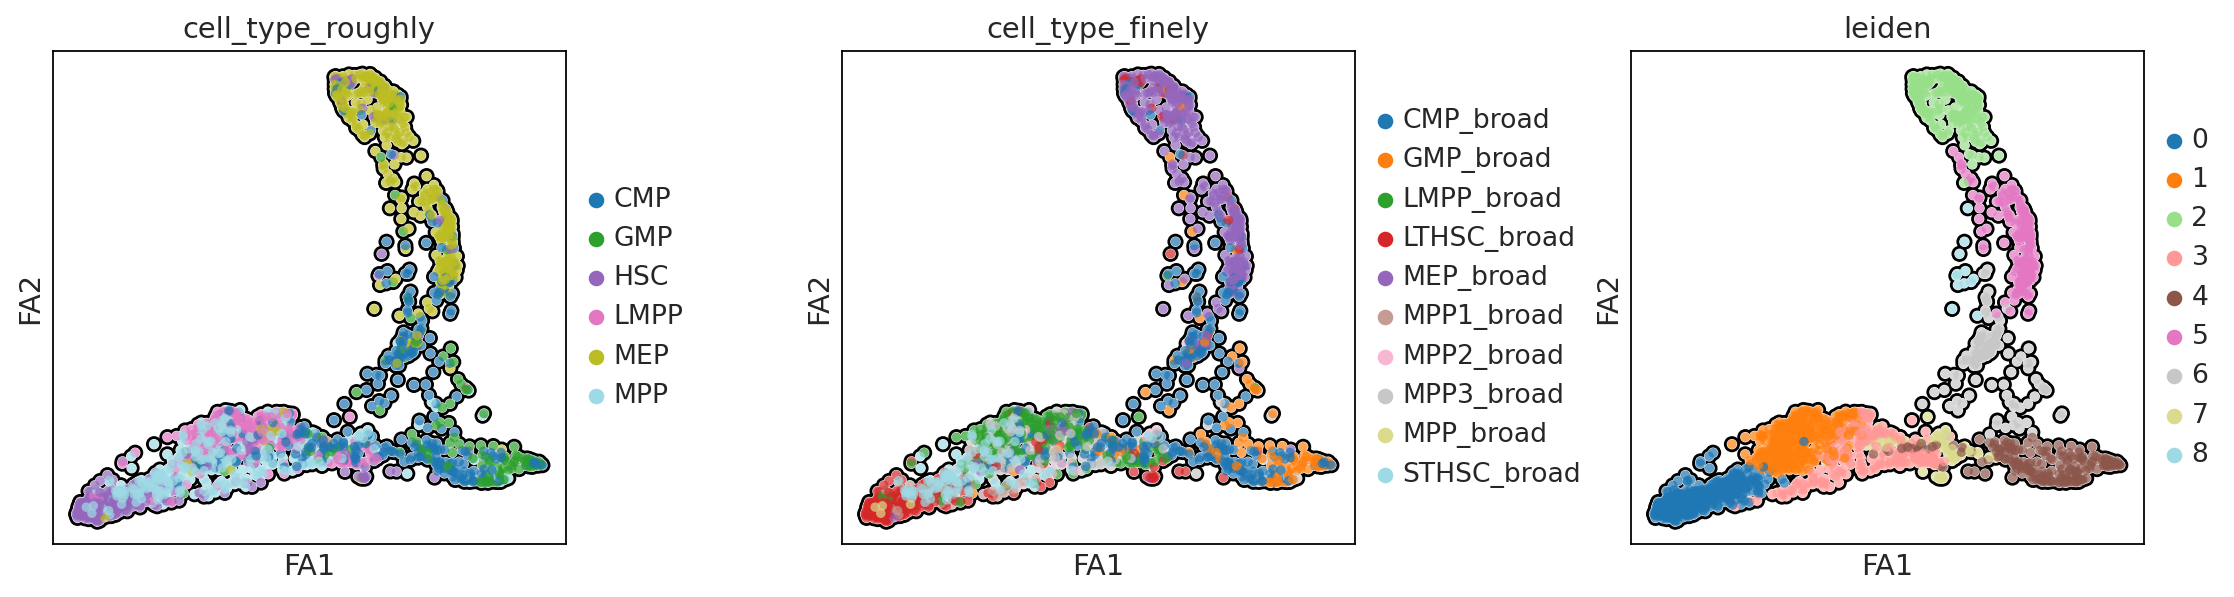

In [12]:
palette = {'HSC':'#9467bd','MPP':'#9edae5','CMP':'#1f77b4','GMP':'#2ca02c','MEP':'#bcbd22','LMPP':'#e377c2'} # from tab20
sc.pl.draw_graph(
    adata,
    color=['cell_type_roughly', 'cell_type_finely', 'leiden'],
    add_outline=True,
    palette='tab20',
    frameon=True,
    wspace=0.4,
    #legend_loc='on data',
    )

<a id="section9"></a>
## 9. Trajectory inference and differential expression analysis

CEFCON will construct a cell-lineage-specific GRN for each trajectory, so obtaining developmental trajectories is necessary before doing this. We also suggest considering the differential expression levels of genes along individual trajectories.

We have provided functions that call R to run [Slingshot](https://github.com/kstreet13/slingshot) for obtaining trajectory information and [MAST](https://github.com/RGLab/MAST/) for obtaining differential expression information. To do this, the required R packages should be first installed in the R environment, as follows:
```R
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install(c("slingshot", "MAST"))
```
&nbsp;
Then, call the R script in python with the following functions:
```Python
import cefcon as cf
temp_R_dir = 'temp_nestorowa16_results'
os.makedirs(temp_R_dir, exist_ok=True)
cf.utils.prepare_data_for_R(adata, temp_R_dir, reducedDim='X_draw_graph_fa', cluster_label='leiden')
cf.utils.process_Slingshot_MAST_R(temp_R_dir, split_num=4, start_cluster=start_cluster, end_cluster=end_cluster)
```

Any other methods of obtaining trajectory and pseudo-time information can be used. If the developmental trajectories with pseudotime are given, we still provide functions that only use MAST to obtain differential expression information of genes. 
Here, we directly use the trajectory information obtained from [Beeline](https://doi.org/10.5281/zenodo.3701939), and then call the R script in python to obtain differential expression information of genes along each trajectory.


In [13]:
# Load pseudotime information for each lineage
cell_lineage_info = pd.DataFrame(np.zeros((len(cell_labels),3)),
                                 index=cell_labels.index,
                                 columns=['E_pseudotime','GM_pseudotime','L_pseudotime'])
for d in ['E','GM','L']:
    l = pd.read_csv('./mHSC_Nestorowa16_data/PseudoTime_{}.csv'.format(d),
                    index_col=0)
    l.index = ['{}-{}'.format(*(i.split('_',1))) if i.startswith('LT') else i
               for i in l.index]
    cell_lineage_info['{}_pseudotime'.format(d)] = l['PseudoTime']

adata.obs['ME_lineage'] = cell_lineage_info['E_pseudotime']
adata.obs['GM_lineage'] = cell_lineage_info['GM_pseudotime']
adata.obs['L_lineage'] = cell_lineage_info['L_pseudotime']

adata.uns['lineages'] = ['ME_lineage', 'GM_lineage', 'L_lineage']

In [14]:
# Obtain differential expression information of genes along each trajectory
import cefcon as cf
temp_R_dir = 'temp_nestorowa16_results'
os.makedirs(temp_R_dir, exist_ok=True)

cf.utils.prepare_data_for_R(adata, temp_R_dir)
cf.utils.process_MAST_R(temp_R_dir, split_num=4)

Running MAST using: 'Rscript /home/wangpeizhuo/cefcon/MAST_script.R temp_nestorowa16_results 4'

It will take a few minutes ...
Done. The results are saved in 'temp_nestorowa16_results'.
      Differential expression information: 'DEgenes_MAST_sp4_<x>.csv'


In [15]:
# Add gene differential expression information into anndata
for lin in adata.uns['lineages']:
    DE_genes = pd.read_csv(temp_R_dir + f'/DEgenes_MAST_sp4_{lin}.csv', index_col=0)
    adata.var[lin+'_logFC'] = DE_genes['logFC']

Check the lineages:

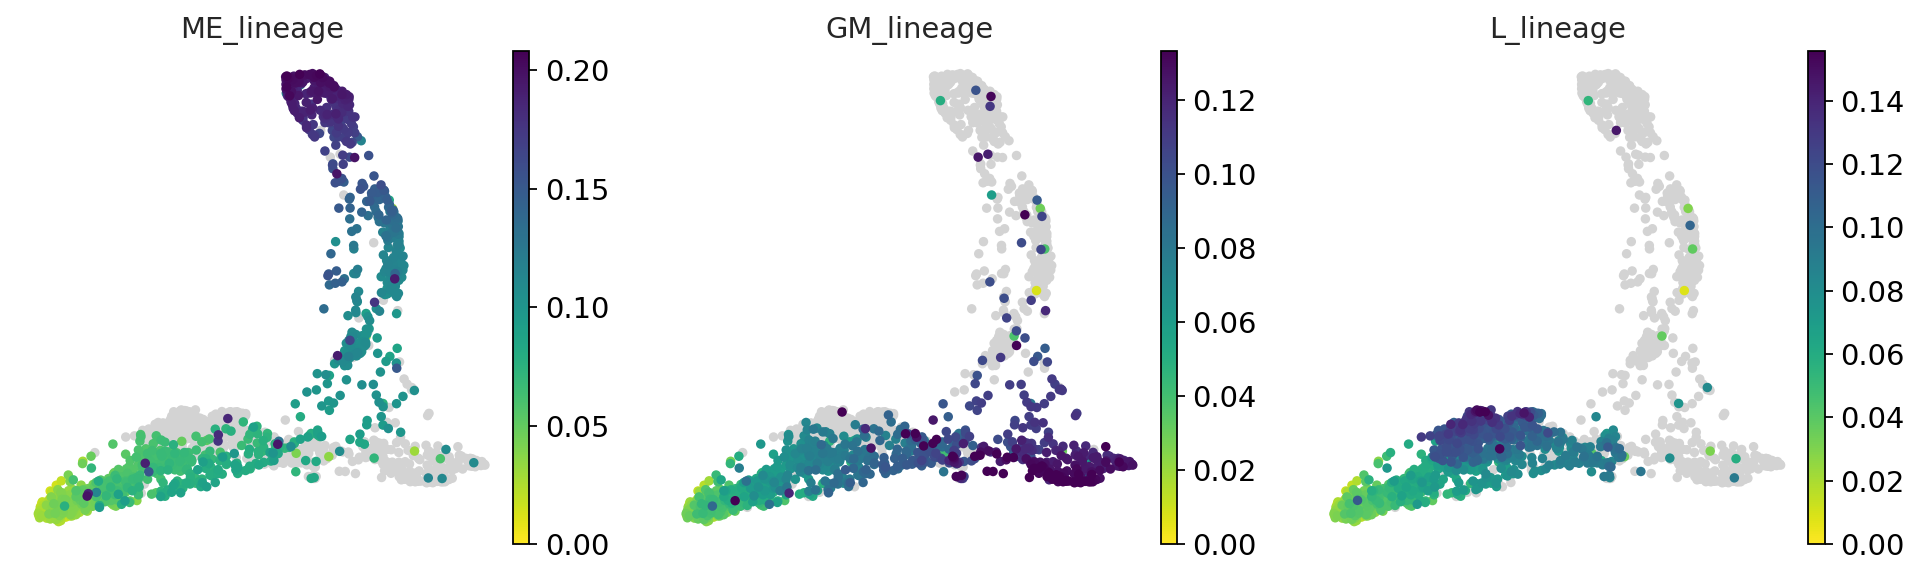

In [16]:
sc.pl.draw_graph(
    adata,
    color=adata.uns['lineages'],
    ncols=4,
    wspace=0.2,
)

<a id="section10"></a>
## 10. Save the preprocessed adata

In [17]:
adata.write_h5ad("mouse_HSC_nestorowa16_v1.h5ad")